In [3]:
import numpy as np
import pandas as pd
import pulp as lp
import pickle as pkl
import time
import matplotlib.pyplot as plt
import datetime as dt
import ALMplanner as ALM

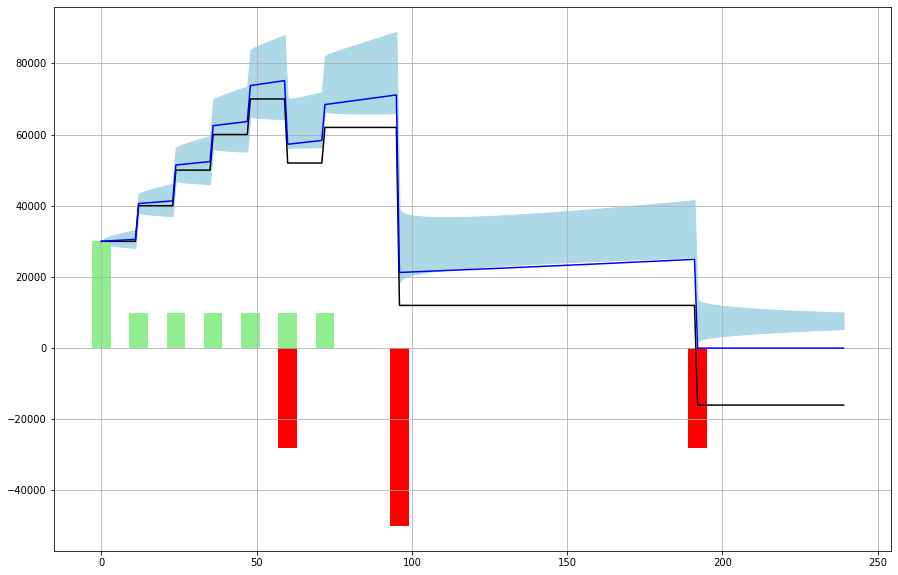

In [84]:
problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2041", user_risk_profile = 0)
# set planned liabilities
problem.liabilities.insert("car", "Jan 2026", 28000, 28000*0.65)
problem.liabilities.insert("university", "Jan 2029", 50000, 50000*0.95)
problem.liabilities.insert("hawaii", "Jan 2037", 28000, 28000*0.85)
# set planned assets 
problem.assets.insert("ass_0","Jan 2021",30000)
recurrent_dates = ["Jan 2022", "Jan 2023", "Jan 2024", "Jan 2025", "Jan 2026", "Jan 2027"]
for i in np.arange(len(recurrent_dates)):
    problem.assets.insert("ass_" + str(i+1),recurrent_dates[i],10000)

problem.display(bar_width = 6)

In [70]:

def smart_asset_allocation(Planner):
    Assets_list = Planner.assets.lists()
    Liabs_list = Planner.liabilities.lists()
    
    Lt = Liabs_list["Month since Start"]
    L = Liabs_list.index
    Liab_tg = Liabs_list["Target Liability"]
    Liab_lb = Liabs_list["Lowerbound Liability"]
    At = Assets_list["Month since Start"]
    A = Assets_list.index
    Assets = Assets_list["Asset Value"]

    asset_split = pd.DataFrame(0,columns = L, index = A)
    total_asset = Assets.sum()
    total_liab_lb = Liab_lb.sum()
    budget = {}
    for l in L:
        budget[l] = min(Liab_lb[l], Liab_lb[l]/total_liab_lb*total_asset)

    for l in L:
        for a in A:
            asset_split[l][a] = min(max(Assets[a] - asset_split.loc[a,:].T.sum(),0), budget[l] - asset_split[l].sum())

    return asset_split


A = smart_asset_allocation(problem)

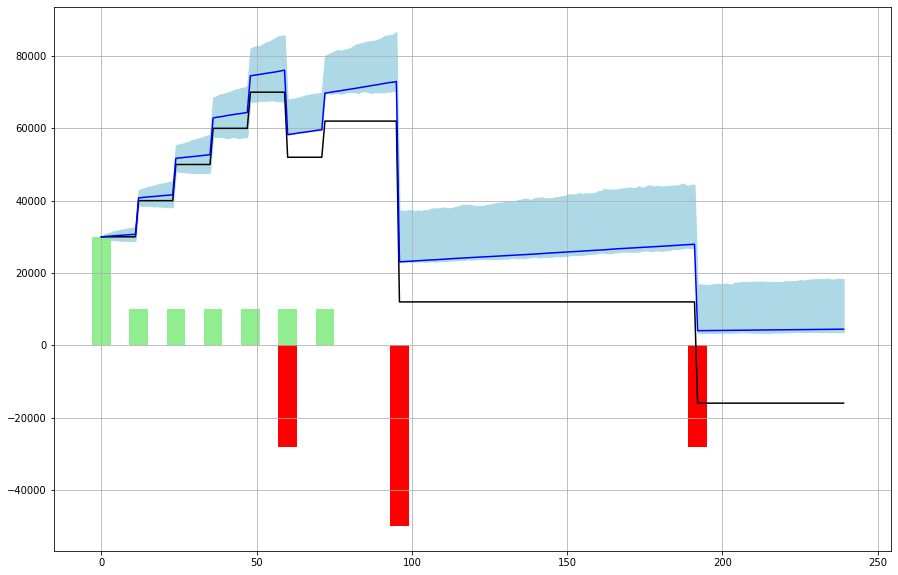

In [87]:

def display(self, bar_width):
    Scenario_file = open( "scenario\ETF_GBM.pkl", "rb")
    ETF_GBM = pkl.load(Scenario_file)
    Scenario_file.close()
    #Scenario_ptf = np.zeros(shape = (len(self.N),self.Scenario[self.P[0]][0].shape[0]))
    
    portfolio = pd.Series(self.user_portfolio.values(),index = self.user_portfolio.keys())
    userpf_capfact = np.dot(np.exp(ETF_GBM[P]), portfolio)
    cap_factor_ptf = np.reshape(userpf_capfact, (int(len(userpf_capfact)/len(N)),len(self.N)))

    
    #mu = np.dot(self.Scenario_mu, portfolio)
    #sigma = np.sqrt(np.dot(np.dot(portfolio,self.Scenario_sigma),portfolio))

    T = pd.date_range(self.start, self.end, freq="M")
    month = np.arange(len(T))

    Assets = self.assets.lists()
    Liabilities = self.liabilities.lists()

    SMF = pd.DataFrame({"Date":T,"Month since Start":month}).merge(Assets[["Month since Start","Asset Value"]], how = "left", on = "Month since Start").merge(Liabilities[["Month since Start","Target Liability", "Lowerbound Liability", "CVaR Level"]], how = "left", on = "Month since Start").fillna(0).reset_index()

    Ass_val = SMF["Asset Value"]
    Liab_val = SMF["Target Liability"]
    low_Liab_val = SMF["Lowerbound Liability"]

    capitalized_value = np.zeros(shape = (len(month), len(N)))
    capitalized_value_lowercase = np.zeros(shape = (len(month), len(N)))
    for i in month:
        if i==0:
            capitalized_value[i,:] = Ass_val[i]
            capitalized_value_lowercase[i,:] = Ass_val[i]
        else:
            capitalized_value[i,:] = np.maximum(capitalized_value[i-1,:] * cap_factor_ptf[i,:] + Ass_val[i] - Liab_val[i],0)
            capitalized_value_lowercase[i,:] = np.maximum(capitalized_value_lowercase[i-1,:] * cap_factor_ptf[i,:] + Ass_val[i] - low_Liab_val[i], 0)

    avg_capitalized_value = np.mean(capitalized_value,axis=1)
    up_capitalized_value = np.quantile(capitalized_value,0.95, axis=1)
    low_capitalized_value = np.quantile(capitalized_value_lowercase,0.05, axis=1)

    plt.figure(figsize = (15,10))
    plt.bar(x = SMF.index, height = SMF["Asset Value"], width = bar_width, color = "lightgreen")
    plt.bar(x = SMF.index, height = -SMF["Target Liability"], width = bar_width, color = "red")
    plt.plot(SMF.index, np.cumsum(SMF["Asset Value"])-np.cumsum(SMF["Target Liability"]), color = "black")
    plt.plot(SMF.index, avg_capitalized_value, color = "blue")
    plt.fill_between(SMF.index,up_capitalized_value,np.minimum(low_capitalized_value, avg_capitalized_value), color = "lightblue")
    #plt.fill_between(SMF.index,avg_capitalized_value,low_capitalized_value, color = "lightblue")
    plt.grid()

    plt.show()
    return

display(problem, bar_width=6)

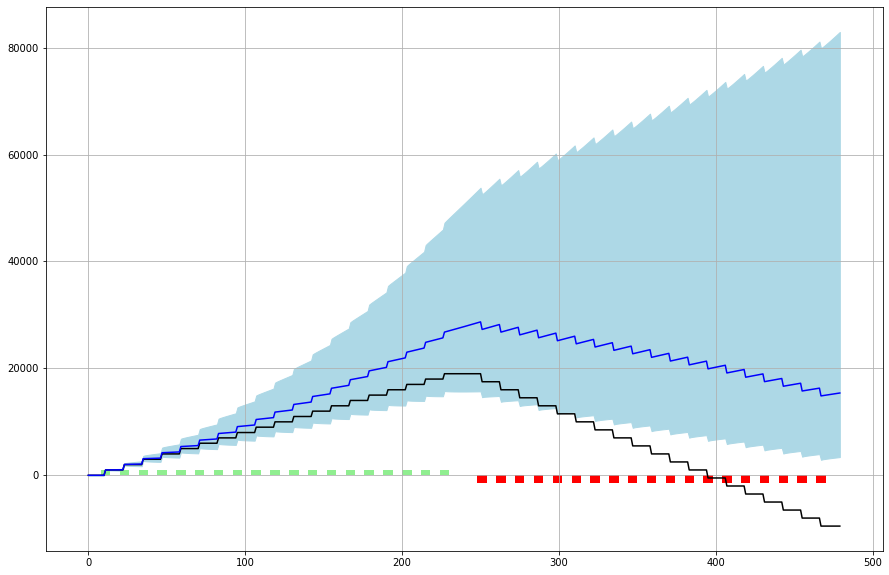

In [82]:
problem = ALM.ALMPlanner(start = "Jan 2021", end = "Jan 2061")
# set planned liabilities
recurrent_assets = pd.date_range(start = "Jan 2021", end="Jan 2040", freq = "Y")
for i in np.arange(len(recurrent_assets)):
    problem.assets.insert("ass_" + str(i+1),recurrent_assets[i],1000)
recurrent_liabilities = pd.date_range(start = "Jan 2041", end="Jan 2060", freq = "Y")
for i in np.arange(len(recurrent_liabilities)):
    problem.liabilities.insert("liab_" + str(i+1),recurrent_liabilities[i],1500,1100)

problem.display(bar_width = 6)

In [32]:
problem.generate_model()
problem.solve()

Model generated in 8.17 s
Solve ended in 4.45 s with Optimal solution


# Display solution

In [33]:
P = problem.P
A = problem.assets.set
L = problem.liabilities.set
N = problem.N
T = problem.T
Scenario = problem.Scenario

In [34]:
Assets_l = {}
Assets_end = {}
for a in A:
    Assets_l[a] = np.zeros(shape = (len(L), len(P)))
    Assets_end[a] = np.zeros(shape = (len(P)))
    for p in np.arange(len(P)):
        Assets_end[a][p] = problem.solution.asset_end_part[a][P[p]]
        for l in np.arange(len(L)):
            Assets_l[a][l,p] = problem.solution.asset_part[a][L[l]][P[p]]

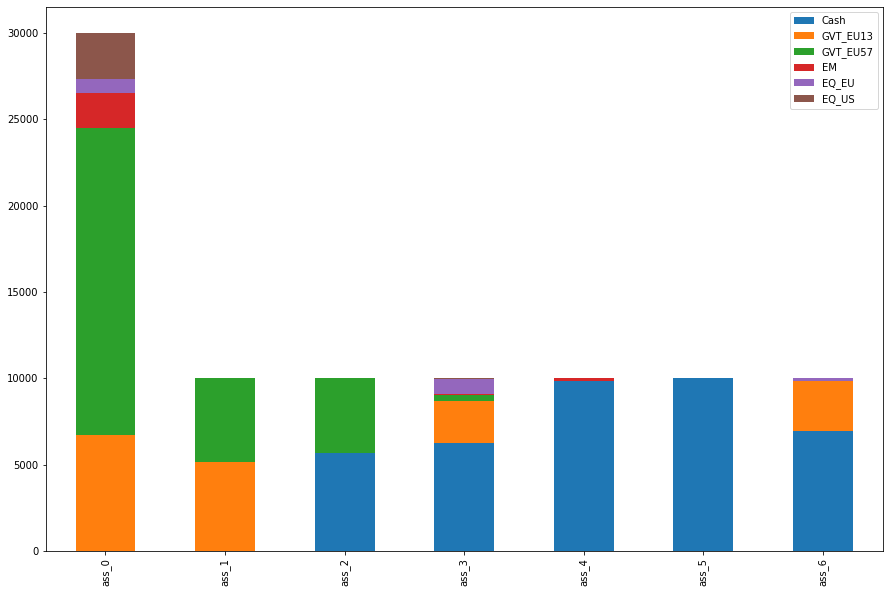

In [35]:
#AssetPerETF
AssetPerETF = {}
for a in A:
    Asset_ap = np.sum(Assets_l[a], axis = 0) + Assets_end[a] 
    AssetPerETF[a] = {P[p]:Asset_ap[p] for p in np.arange(len(P))}

AssetPerETF = pd.DataFrame(AssetPerETF).transpose()
AssetPerETF.plot.bar(stacked = True, figsize = (15,10))
plt.show()

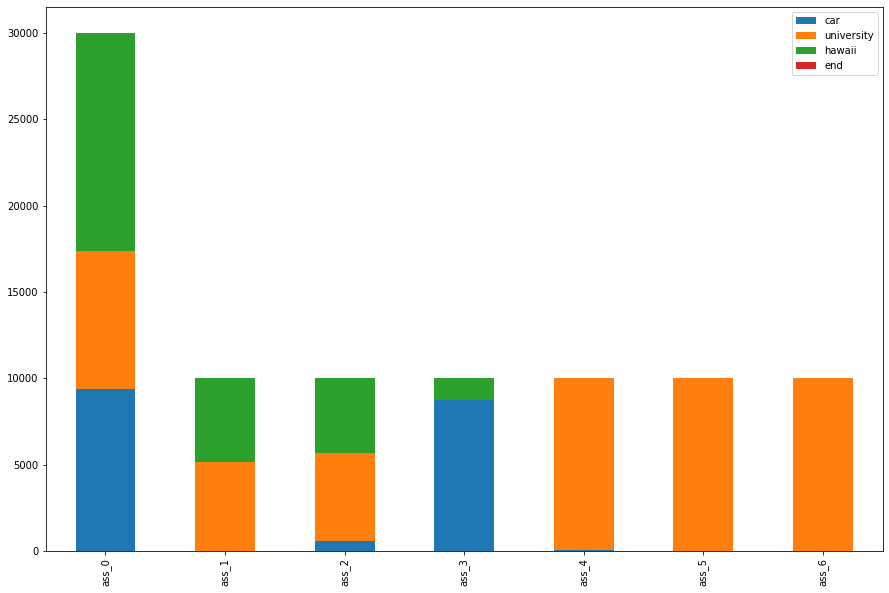

In [36]:
AssetPerLiab = {}
for a in A:
    Asset_al = list(np.sum(Assets_l[a], axis = 1))
    Asset_al.append(np.sum(Assets_end[a]))
    L_end = list(L)
    L_end.append("end")
    AssetPerLiab[a] = {L_end[l]:Asset_al[l] for l in np.arange(len(L_end))}

AssetPerLiab = pd.DataFrame(AssetPerLiab).transpose()
AssetPerLiab.plot.bar(stacked = True, figsize = (15,10) )
plt.show()

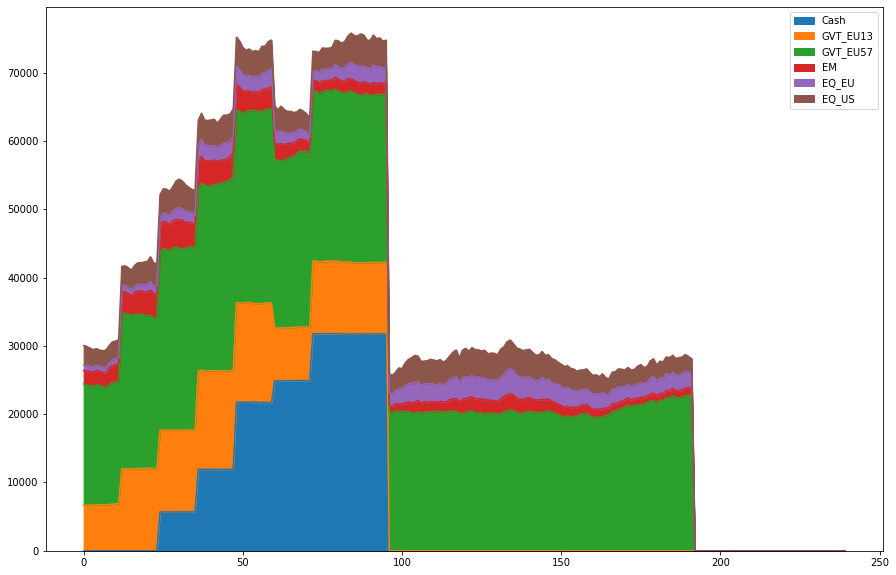

In [37]:
n_scen = 5
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [problem.solution.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])

            elif t == problem.liabilities.period[L[l]]:
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [problem.solution.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario[p][n_scen][t])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AssetAllocationNominal.plot.area(figsize = (15,10))
plt.show()

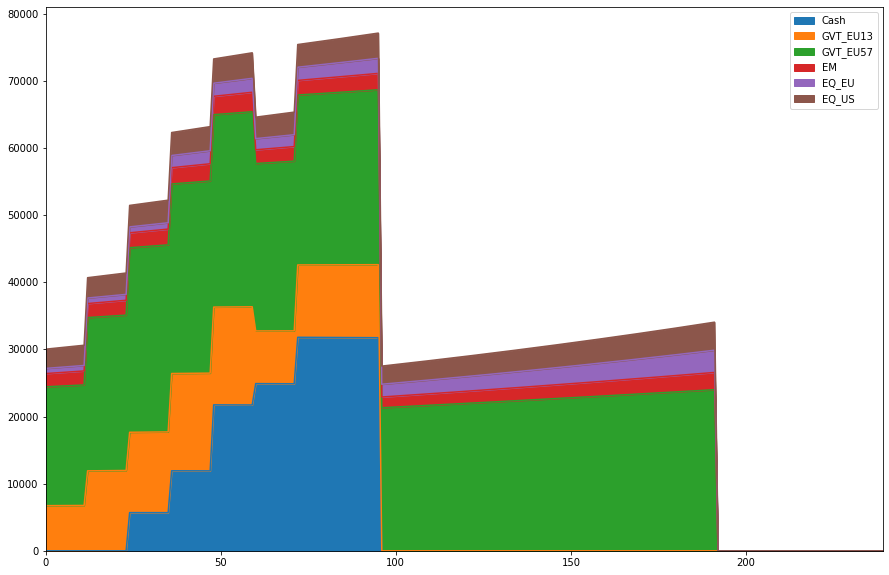

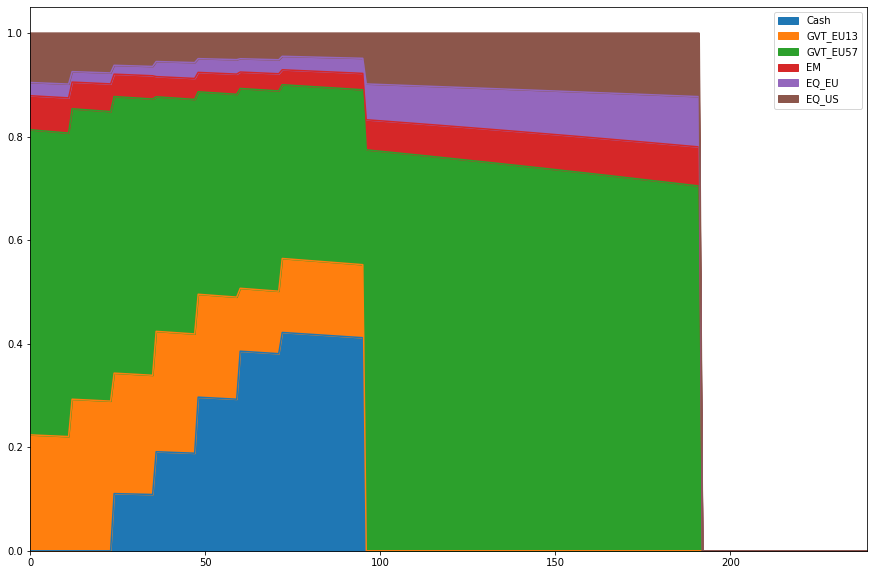

In [38]:
Scenario_mu = problem.Scenario_mu
#print([solution[l][n_scen].varValue for l in Lt])
Q_nscen = np.zeros(shape = (len(P),len(L)))
Val_tl = {}
i = -1
At = sorted(list(problem.assets.period.values()))
label_period = [[k, v] for k,v in problem.assets.period.items()]
label_value = [[k, v] for k,v in problem.assets.value.items()]
period_value_df = pd.DataFrame(label_period, columns = ["Label", "Period"]).merge(pd.DataFrame(label_value, columns = ["Label", "Value"]))

for p in P:
    i = i+1
    Val_tl[p] = np.zeros(shape = (len(T), len(L)))
    for l in np.arange(len(L)):
        for t in np.arange(len(T)):
            if t < problem.liabilities.period[L[l]]:
                new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
                new_asset = [problem.solution.asset_part[a][L[l]][p] for a in new_asset_label]
                if t==0:
                    Val_tl[p][t,l] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
                else:
                    Val_tl[p][t,l] = (Val_tl[p][t-1,l] + sum(new_asset))*np.exp(Scenario_mu[p])

            elif t == problem.liabilities.period[L[l]]:
                Q_nscen[i,l] = Val_tl[p][t-1,l]
    
Val_end_t = {}
for p in P:
    Val_end_t[p] = np.zeros(shape = (len(T)))
    for t in np.arange(len(T)):
        new_asset_label = period_value_df.loc[period_value_df.Period == t , "Label" ].values
        new_asset = [problem.solution.asset_end_part[a][p] for a in new_asset_label]
        if t==0:
            Val_end_t[p][t] = sum(new_asset)*np.exp(Scenario[p][n_scen][t])
        else:
            Val_end_t[p][t] = (Val_end_t[p][t-1] + sum(new_asset))*np.exp(Scenario_mu[p])


Val_t = {}
for p in P:
    Val_t[p] = np.sum(Val_tl[p], axis = 1) + Val_end_t[p] 

AssetAllocationNominal = pd.DataFrame(Val_t)
AssetAllocationNominal[AssetAllocationNominal<0] = 0
AAN_perc = AssetAllocationNominal.divide(AssetAllocationNominal.sum(axis=1), axis=0)
AssetAllocationNominal.plot.area(figsize = (15,10))
plt.margins(0,0)
plt.show()
AAN_perc.plot.area(figsize = (15,10))
plt.margins(0,0)
plt.show()

In [25]:
Q_ln = {}
for l in L:
    Q_ln[l] = np.zeros(shape = (len(N)))
    for n in N:
        Q_ln[l][n]=problem.solution.liab_distr[l][N[n]]



for l in L:
    affordable_short = Q_ln[l] < problem.liabilities.value_tg[l]
    fail_short = Q_ln[l] < problem.liabilities.value_lb[l]
    print(np.mean(affordable_short) )
    print(np.mean(fail_short) )
    print(np.mean(Q_ln[l][affordable_short]))
    print(np.mean(Q_ln[l][Q_ln[l] <= np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])]))
    print(l,":", problem.liabilities.value_tg[l], ", LB:", problem.liabilities.value_lb[l], ", Solution Cvar:", np.round(np.mean(Q_ln[l][Q_ln[l] <= np.quantile(Q_ln[l],1-problem.liabilities.cvar_lim[l])]),2), ", min: ", np.min(Q_ln[l]))


0.996
0.023
18858.84279819277
16271.476358490569
car : 25000 , LB: 16250.0 , Solution Cvar: 16271.48 , min:  15428.51
0.559
0.019
48878.43676565296
47511.05246153847
university : 50000 , LB: 47500.0 , Solution Cvar: 47511.05 , min:  46653.657
0.147
0.024
27589.511972789114
25630.105074074072
hawaii : 30000 , LB: 25500.0 , Solution Cvar: 25630.11 , min:  20869.475
